In [1]:
import torch
import foolbox as fb
import timm
from PIL import Image
from urllib.request import urlopen
import requests
import numpy as np
import torchvision as tivision

/home/michaelangelo/Benchmark-of-Methods-for-Adversarial-Attacks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mobile_model = timm.create_model('tf_mobilenetv3_large_minimal_100.in1k', pretrained=True)
mobile_model = mobile_model.cuda().eval()

mobile_data_config = timm.data.resolve_model_data_config(mobile_model)
mobile_transforms = timm.data.create_transform(**mobile_data_config, is_training=False)

In [6]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(url).json()

In [16]:
def fool_model_with_cwl2(image_url: str, model):
    if not model:
        model = timm.create_model('vgg16.tv_in1k', pretrained=True)
        model.eval()
        model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = 123

    label = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.TargetedMisclassification(label)

    attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=10,steps = 100, stepsize=0.1, confidence=0.0)
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [17]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_cwl2(    'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg', mobile_model )


In [19]:
print(adversarial_label)
print(imagenet_labels[adversarial_label])

123
spiny lobster


In [ ]:
print(success)
print(torch.softmax(mobile_model(raw_adversarial), dim=1).max())
print(torch.softmax(mobile_model(clipped_adversarial), dim=1).max())

tensor([False], device='cuda:0')
tensor(0.2004, device='cuda:0', grad_fn=<MaxBackward1>)


In [29]:
image_url = 'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg'
image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
])

img = Image.open(urlopen(image_url))
img_tensor = image_transforms(img).unsqueeze(0).cuda()
    
print(torch.softmax(mobile_model(img_tensor), dim=1).max())

tensor(0.9826, device='cuda:0', grad_fn=<MaxBackward1>)


(1, 3, 224, 224)

np.float32(2.8431943e-09)

np.float32(0.9489854)

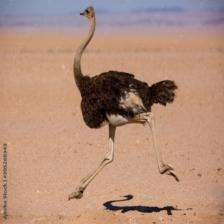

np.float32(2.0861626e-07)

np.float32(0.9465109)

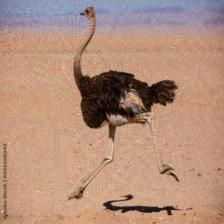

In [26]:
#dispaly shape of the clipped_adversarial

display(clipped_adversarial.cpu().detach().numpy().shape)
#display min and max value of clipped_adversarial
display(clipped_adversarial.cpu().detach().numpy().min())
display(clipped_adversarial.cpu().detach().numpy().max())
tivision.utils.save_image(clipped_adversarial, 'adversarial_image.jpg')
#display the image
Image.open('adversarial_image.jpg').show()
# display(raw_adversarial)
#min max value of raw_adversarial
display(raw_adversarial.cpu().detach().numpy().min())
display(raw_adversarial.cpu().detach().numpy().max())
tivision.utils.save_image(raw_adversarial, 'raw_adversarial_image.jpg')
Image.open('raw_adversarial_image.jpg').show()
